In [1]:
#Use a short time of frames to calbirate the camera#
from geometry import gen_focal_length
from camera_utils import Camera, AerialView
from geometry_3d import Rotation
from calib_losses import constrained_alpha_beta_fov_loss
import numpy as np
import os
import cv2
from scipy import optimize
import argparse
import json

from visualize import create_black_board, draw_text, vis_xyz_as_images, vis_box_pairs
from datasets_v3_v3 import BoxDataLoader
from utils import load_seq_info, save_to_json


from const import MOT17_SEQ_NAMES, MOT17_TRAIN_SEQ_NAMES, MOT20_TRAIN_SEQ_NAMES, RANDOM_COLORS
from yolox.camera.img_vis import draw_box, draw_corners, draw_boxes

import time

def gen_dir(folder):
    if not os.path.exists(folder): 
        os.system(f'mkdir -p {folder}')

def get_box_pts(boxes, 
                loc = 'bottom'):
    if loc == 'center':
        box_pts = boxes[:, :2] + boxes[:, 2:] / 2
    elif loc == 'bottom':
        box_pts = boxes[:, :2].copy()
        box_pts[:, 0] += boxes[:, 2] / 2 # x + w/2
        box_pts[:, 1] += boxes[:, 3]     # y + h
    return box_pts

def get_xy_ranges(a_view, tracks):

    boxes = tracks.reshape((-1, 4))
    mask  = boxes[:, 2] * boxes[:, 3] > 0
    boxes = boxes[mask]

    xyh = a_view.compute_xyh_from_boxes(boxes)
    xmin, xmax = xyh[:, 0].min(), xyh[:, 0].max()
    ymin, ymax = xyh[:, 1].min(), xyh[:, 1].max()

    return [xmin, ymin, xmax, ymax]


def dec_calib(boxes, bounds, a_view, 
              use_core = True):

    alpha, beta, fov = bounds

    new_boxes = boxes.copy()
    if use_core:
        centers = boxes.copy()
        centers[:, :, :2] += boxes[:, :, 2:] / 2
        centers[:, :, 2]   = centers[:, :, 3] / 4
        centers[:, :, :2] -= centers[:, :, 2:] / 2
        new_boxes          = centers

    params  = (a_view, new_boxes)
    result  = optimize.differential_evolution(constrained_alpha_beta_fov_loss, [alpha, beta, fov], args = params, 
                    updating='deferred', tol = 1e-10, workers=20, disp = False, popsize=50)

    alpha, beta, fov = result.x

    return np.array([alpha, beta, fov]), result.fun

def get_params():
    parser = argparse.ArgumentParser()
    parser.add_argument("--dataset_name", type=str, default = 'mot')
    parser.add_argument("--subset",       type=str, default = 'train')    
    parser.add_argument("--seq_name",     type=str, default = 'MOT17-13-FRCNN')
    parser.add_argument("--use_gt",       action="store_true", help="use ground truth or not")
    parser.add_argument("--workers",      type=int, default = 20)
    parser.add_argument("--popsize",      type=int, default = 50) 
    parser.add_argument("--start",        type=int, default = 0)
    parser.add_argument("--window",       type=int, default = 3)
    args = parser.parse_args()
    return args

/home/shenghua/miniconda3/envs/pt3_gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# args = get_params()
# print(args)
root_dir = os.path.abspath('../')
proj_name    = 'calib_v3'         # dynamic update for a moving camera
# dataset_name = args.dataset_name
# subset       = args.subset
# seq_name     = args.seq_name

# use_gt   = args.use_gt

dataset_name = 'mot'
subset       = 'train'
seq_name     = 'MOT17-13-FRCNN'

use_gt       = True
use_core     = True
use_ecc      = False
time_window  = 5
num_frames   = 750
multi_ecc    = False

print('------------------------------------------------\n')
seq_info_file = os.path.join(root_dir, 'datasets', 
                    dataset_name, subset,  seq_name, 'seqinfo.ini')
seq_info = load_seq_info(seq_info_file)
print(seq_info)

calib_res_dir = os.path.join(root_dir, 'calib_results_v3', dataset_name)
gen_dir(calib_res_dir)

# intialize aerial view objects for calibration
w_img, h_img = seq_info['w_img'], seq_info['h_img']
rotation     = Rotation(np.array([0, 0, 0]))
camera       = Camera(w_img = w_img, h_img = h_img, 
                        cx = w_img / 2, cy = h_img / 2)

a_view        = AerialView(camera, rotation)

# load data for calibration
if use_gt:
    track_file = os.path.join(root_dir, 'datasets', dataset_name, subset, seq_name, 'gt/gt.txt')
else:
    if seq_name in MOT17_SEQ_NAMES:
        track_file = os.path.join(root_dir, 'results', f'mot17_paper_v3/bytetrack/{seq_name}.txt')
    else:
        track_file = os.path.join(root_dir, 'results', f'mot20_paper/yolox_x_mix_mot20_ch/bytetrack/{seq_name}.txt')

boxloader    = BoxDataLoader(track_file = track_file,
                            img_size           = (w_img, h_img),
                            window             = int(seq_info['fps'] * 2),
                            stride             = seq_info['fps'] // 2,
                            height_dif_thresh  = 3,
                            front_ratio_thresh = 0.8,
                            fps                = seq_info['fps'],
                            use_ecc            = use_ecc,
                            multi_ecc          = multi_ecc,
                            img_dir            = os.path.join(root_dir, 'datasets', dataset_name, subset, seq_name, 'img1'),
                            time_window        = time_window,
                            num_frames         = num_frames)

# mask = boxloader.raw_tracks[:, 0, -1] > 0
# print(mask.sum())

------------------------------------------------

{'seq_name': 'MOT17-13-FRCNN', 'fps': 25, 'seq_len': 750, 'w_img': 1920, 'h_img': 1080}
track numpy shape: (188, 750, 4)
track numpy shape: (188, 750, 4)


In [3]:
# start_frame = args.start
# time_window  = args.window
proj_name    = 'calib_v4'         # dynamic update for a moving camera
frame_window = time_window * seq_info['fps']
print(frame_window)
start_frame  = 0

for start_frame_id in range(num_frames):
    end_frame_id = start_frame_id + frame_window
    ref_frame_id = start_frame_id + frame_window // 2
    # boxes = boxloader.get_boxe_pairs_by_window(start_frame, end_frame - start_frame)
    boxes = boxloader.get_ecc_warpped_boxes(start_frame_id, frame_window)
    print(f'-------------------------------------------------------------------------')
    print(f'start_frame: {start_frame_id}, end_frame: {start_frame_id + frame_window - 1}, ref_frame: {ref_frame_id}, samples: {boxes.shape}')
    num_camples = boxes.shape[0]

    # perform calibration
    start_time = time.time()
    bounds   = ((20, 100), (-10, 10), (30, 150))
    result, loss_val = dec_calib(boxes, bounds, a_view, use_core = use_core)
    end_time   = time.time()
    duration = end_time - start_time
    # print(f'duration: {round(duration, 2)}s')

    alpha, beta, fov = result
    alpha, beta, fov = float(alpha), float(beta), float(fov)
    print(f'alpha: {round(alpha, 2)}, beta: {round(beta, 2)}, fov: {round(fov, 2)}, loss:{round(loss_val, 6)} dur: {round(duration, 2)} s')

    cam_info = {'w_img': w_img, 'h_img': h_img,
                'alpha': alpha, 'beta': beta, 'fov': fov}

    cam_info_file = calib_res_dir + f'/{seq_name}_{start_frame_id}_{end_frame_id}.json' if use_gt else calib_res_dir + f'/{seq_name}_trk.json'
    save_to_json(cam_info_file, cam_info)

    # visualize calibration result
    track_dir     = os.path.join(root_dir, 'results', proj_name, dataset_name, seq_name)
    if not use_gt: track_dir += '_trk'
    res_dir       = track_dir + f'/ground_floor_{frame_window}'
    gen_dir(res_dir)

    dis_dir   = track_dir + f'/distribution_{frame_window}'
    gen_dir(dis_dir)
    vis_board = vis_box_pairs(w_img, h_img, boxes)
    cv2.imwrite(dis_dir + f'/{seq_name}_{start_frame_id}-{end_frame_id}_box_distributioin.png', vis_board)

    all_tracks    = boxloader.raw_tracks
    all_track_ids = boxloader.track_ids

    # print(all_tracks.shape)
    img_size = h_img // 2

    xy_ranges = get_xy_ranges(a_view, all_tracks)  # define xy ranges for visualization

    img_dir   = os.path.join(root_dir, 'datasets', dataset_name, subset, seq_name, 'img1')

    # for frame_id in range(num_frames):
    frame_id = (start_frame_id + end_frame_id) // 2

    if dataset_name == 'dancetrack':
        img_file = img_dir + '/{:08d}.jpg'.format(frame_id + 1)
    else:
        img_file = img_dir + '/{:06d}.jpg'.format(frame_id + 1)

    frame     = cv2.imread(img_file)
    
    boxes        = all_tracks[:, frame_id, :]
    box_mask     = boxes[:, 2] * boxes[:, 3] > 0
    boxes        = boxes[box_mask, :]

    track_ids    = all_track_ids[box_mask]
    xyh          = a_view.compute_xyh_from_boxes(boxes)
    bot_centers  = get_box_pts(boxes)

    draw_img = frame.copy()
    for i in range(bot_centers.shape[0]):
        track_id = track_ids[i]
        draw_text(draw_img, f'frame_id: {frame_id}', (5, 20), color = (0, 255, 0), scale = 1, thickness = 2)
        draw_corners(draw_img, bot_centers[i, :].reshape((-1, 2)), color = RANDOM_COLORS[track_id].tolist(), dot_size = 3)
        draw_box(draw_img, boxes[i, :], color = RANDOM_COLORS[track_id].tolist(), thickness = 2)

    if bot_centers.shape[0] == 0: continue

    # draw xyh in aerial view
    vis_3d_draw = vis_xyz_as_images(xyh, track_ids, xy_ranges, img_size = img_size, dot_size = 5, 
                        scale = 1, thickness = 2, orient_angle = 0, r = 10, arrow_thickness = 2, colors = RANDOM_COLORS)
    blk_board   = create_black_board(img_size, h_img)
    blk_board[h_img // 2 - img_size // 2: h_img // 2 + img_size // 2, :] = vis_3d_draw

    # draw parameters in figure
    row_size    = 35
    py1 = h_img // 2 + img_size // 2 + row_size
    draw_text(blk_board, f'al, bt, fov: {round(alpha, 2)} {round(beta, 2)} {round(fov, 2)}', (5, py1), color = (0, 255, 0), scale = 1, thickness = 3)
    py2 = h_img // 2 + img_size // 2 + row_size * 2
    draw_text(blk_board, f'samples:{num_camples}, loss:{round(loss_val, 3)}', (5, py2), color = (0, 255, 0), scale = 1, thickness = 3)

    img_pts = a_view.project_xyh_to_img(xyh)
    img_pts = np.int16(img_pts)

    thickness = 2
    for i in range(img_pts.shape[0]):
        top_pt = img_pts[i, 0, :]
        bot_pt = img_pts[i, 1, :]
        track_id = track_ids[i]
        cv2.line(draw_img, top_pt, bot_pt, (0, 0, 255), thickness)

    concat = cv2.hconcat([draw_img, blk_board])
    cv2.imwrite(res_dir + f'/image_{seq_name}_{start_frame_id}-{end_frame_id}_{round(alpha, 2)}_{round(beta, 2)}_{round(fov, 2)}_gt_{use_gt}.png', concat)

    # start_frame += frame_window

125
-------------------------------------------------------------------------
start_frame: 0, end_frame: 124, ref_frame: 62, samples: (362, 2, 4)
alpha: 84.31, beta: -0.54, fov: 99.63, loss:0.057466 dur: 3.92 s
-------------------------------------------------------------------------
start_frame: 1, end_frame: 125, ref_frame: 63, samples: (359, 2, 4)
alpha: 83.98, beta: 0.62, fov: 91.62, loss:0.060246 dur: 4.16 s
-------------------------------------------------------------------------
start_frame: 2, end_frame: 126, ref_frame: 64, samples: (352, 2, 4)
alpha: 84.01, beta: -0.21, fov: 98.04, loss:0.060228 dur: 4.47 s
-------------------------------------------------------------------------
start_frame: 3, end_frame: 127, ref_frame: 65, samples: (355, 2, 4)
alpha: 83.7, beta: -0.12, fov: 95.19, loss:0.061295 dur: 3.62 s
-------------------------------------------------------------------------
start_frame: 4, end_frame: 128, ref_frame: 66, samples: (357, 2, 4)
alpha: 83.75, beta: -0.02, f

[ WARN:0@8649.579] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/shenghua/video_mot/ByteTrack/datasets/mot/train/MOT17-13-FRCNN/img1/000751.jpg'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'shape'

(188, 750, 4)
[[ 1.35523880e+00  9.07520279e-02 -4.83155861e+01]
 [ 4.27525081e-02  1.28491175e+00 -2.22263985e+01]
 [ 5.04710188e-04  3.87536507e-04  1.00000000e+00]]
(200, 3, 3) (188, 200, 4)
(188, 200, 4)
(1, 200, 3, 3)
(188, 200, 3, 3)
(150400, 3, 3) (150400, 3, 1)
(150400, 3, 1)
(188, 200, 4)
boxes: 23
(188, 4) [0. 0. 0. 0.]


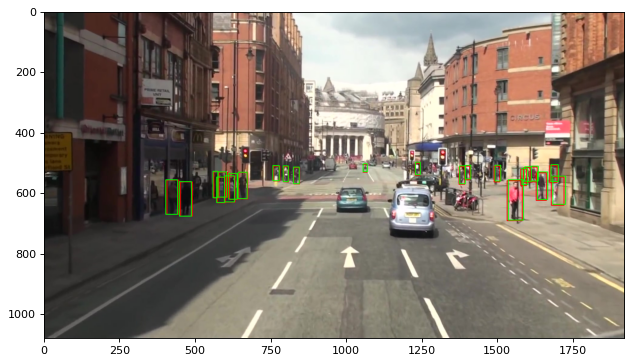

In [ ]:
import matplotlib.pyplot as plt

tracks  = boxloader.raw_tracks
print(tracks.shape)

print(ecc_coefs[0, :])
num      = 200
trks     = tracks[:,:num,:]

ecc_coef = ecc_coefs[:num, :]

print(ecc_coef.shape, trks.shape)
x        = map_to_ref(ecc_coef, trks, dsample = 4)

print(x.shape)


# test for the first two frames
frame_id = 48
frame    = cv.imread(img_dir + '/{:06d}.jpg'.format(frame_id +1))
frame    = cv2.cvtColor(frame, cv.COLOR_RGB2BGR)
draw_fr  = frame.copy()
# box      = tracks[:,frame_id, :]
box      = x[:, frame_id, :]
box0     = trks[:, frame_id, :]
box_mask = box[:, -1] > 0
print(f'boxes: {box_mask.sum()}')
print(box.shape, box[0, :])

draw_boxes(draw_fr, box0[box_mask], color = (255, 0, 0), thickness = 2)
draw_boxes(draw_fr, box[box_mask], color = (0,    255, 0), thickness = 2)


fig = plt.figure(figsize=(8, 8), dpi=80, tight_layout=True)
font_size = 20
ax = fig.subplots(1, 1)
cax = ax.imshow(draw_fr)